In [1]:
from collections import defaultdict
from fnmatch import fnmatch
import os
from Bio import SeqIO, SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd


# Basic Parameters and Load Data

In [2]:
# Parameters
word = 6
step = 1

# Load metadata
metadata_file = '../data/metadata_updated.csv'
metadata = pd.read_csv(metadata_file, sep=';', index_col=False)
elements_files = metadata['Name of elements'].to_list()

In [8]:
# Load sequences
dir_path = r'../data/Angiospermophyta/Monocots/Monocot_Zea_mays/domains'
lines_folder = r'../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINES'
file_list = [name for name in os.listdir(dir_path) if fnmatch(name, "*.fasta")]
files = [dir_path + "/" + file_name for file_name in file_list]

# Functions

In [9]:
def kmers_freq(sequence: str, word: int, step: int) -> defaultdict[str, int]:
    """
    Calculate the frequency of overlapping k-mers in a sequence.

    This function takes a sequence string and calculates the frequency of overlapping
    k-mers of the specified length and step size. It returns a defaultdict that maps
    k-mers to their frequency counts.

    Args:
        sequence (str): The input sequence as a string.
        word (int): The length of each k-mer.
        step (int): The step size for moving the sliding window.

    Returns:
        defaultdict[str, int]: A defaultdict mapping k-mers to their frequency counts.
    """

    index = 0
    seq_len = len(sequence)
    kmers: defaultdict[str, int] = defaultdict(int)
    
    while (index + word) < seq_len:
        kmer = str(''.join(sequence[index : index + word]))
        kmers[kmer] += 1
        index += step
    return kmers

def fill_consecutive_nones(input_list: list) -> list:
    """
    Fills consecutive None values in a list with the last repeated value.
    This function iterates through the input list and replaces consecutive None
    values with the last repeated value. If a None value is not part of a sequence
    of repeated values, it remains unchanged.
    Args:
        input_list (list): The list containing values and None entries.
    Returns:
        list: A new list with consecutive None values filled with the last repeated value.
    """
    
    new_list = []
    last_repeated_value = None 
    
    for i, value in enumerate(input_list):
        if value is None:
            # Replace None only if it belongs to a sequence of repeated values
            if i > 0 and input_list[i - 1] == last_repeated_value:
                new_list.append(last_repeated_value)
            else:
                new_list.append(None)
        else:
            # Update the last_repeated_value only if it's part of a repeating sequence
            if i > 0 and input_list[i - 1] == value:
                last_repeated_value = value
            else:
                last_repeated_value = None  # Reset when encountering a new value
            new_list.append(value)
    
    return new_list

def propagate_values(input_list: list) -> list:
    """
    Propagates the last non-None value in the input list to subsequent None values.
    Args:
        input_list (list): A list of values where some elements may be None.
    Returns:
        list: A new list where None values are replaced by the most recent non-None value.
    """
    
    new_list = []
    current_value = None  # Tracks the current value to propagate
    
    for value in input_list:
        if value is not None:
            # Update the current value whenever we encounter a new non-None element
            current_value = value
        # Add the current value (whether updated or continuing the propagation)
        new_list.append(current_value)
    
    return new_list

def get_regions(df: pd.DataFrame) -> defaultdict(list):
    """
    Extracts regions from a DataFrame and organizes them into a defaultdict of lists.
    This function iterates over the rows of the provided DataFrame and extracts specific regions
    based on the presence of non-null values in certain columns. The regions are stored in a 
    defaultdict with keys representing the region type and values being lists of tuples, where 
    each tuple contains the start and end positions of the region.
    Args:
        df (pd.DataFrame): The input DataFrame containing region information with specific columns.
    Returns:
        defaultdict(list): A defaultdict where keys are region types and values are lists of tuples 
                       representing the start and end positions of the regions.
    """
    
    regions = defaultdict(list)

    # Iterate over rows to access individual values
    for idx, row in df.iterrows():
        if pd.notna(row['ORF 1 RRM início']):
            regions['ORF1_RRM'].append((int(row['ORF 1 RRM início']), int(row['ORF 1 RRM  fim'])))
        if pd.notna(row['ORF 1 DUF início']):
            regions['ORF1_DUF'].append((int(row['ORF 1 DUF início']), int(row['ORF 1 DUF fim'])))
        if pd.notna(row['ORF 1 Zf-CCHC início']):
            regions['ORF1_Zf'].append((int(row['ORF 1 Zf-CCHC início']), int(row['ORF 1 Zf-CCHC fim'])))
        if pd.notna(row['ORF 1 PHA(?) início']):
            regions['ORF1_PHA'].append((int(row['ORF 1 PHA(?) início']), int(row['ORF 1 PHA(?)  fim'])))
        if pd.notna(row['ORF 2 EEP início']):
            regions['EEP'].append((int(row['ORF 2 EEP início']), int(row['ORF 2 EEP  fim'])))
        if pd.notna(row['ORF 2 RT início']):
            regions['RT'].append((int(row['ORF 2 RT início']), int(row['ORF 2 RT fim'])))
        if pd.notna(row['ORF 2 Zf-RVT início']):
            regions['ZF'].append((int(row['ORF 2 Zf-RVT início']), int(row['ORF 2 Zf-RVT  fim'])))
        if pd.notna(row['ORF 2 RH início']):
            regions['RH'].append((int(row['ORF 2 RH início']), int(row['ORF 2 RH fim'])))
        if pd.notna(row['(GTT)n início']):
            regions['(GTT)n'].append((int(row['(GTT)n início']), int(row['(GTT)n fim'])))
        if pd.notna(row['Poli-A início']):
            regions['PoliA'].append((int(row['Poli-A início']), int(row['Poli-A fim'])))
    
    return regions

def create_annot_regions(regions: defaultdict(tuple[int]), seq_len_df: int) -> np.ndarray:
    """
    Create an array of annotation regions based on the provided regions and sequence length.
    Args:
        regions (defaultdict(tuple[int])): A dictionary where keys are annotation labels and values are tuples of start and end indices.
        seq_len_df (int): The length of the sequence for which the annotation regions are to be created.
    Returns:
        np.ndarray: An array of the same length as seq_len_df with annotation labels assigned to the specified regions.
    """
    
    annot_regions = np.array([None]*seq_len_df)
    
    for k, v in regions.items():
        annot_regions[v[0][0]:v[0][1]] = k
    return annot_regions

# k-mers count

In [10]:
kmers = defaultdict(lambda: defaultdict(int))
count_seq = defaultdict(int)
for file_in in files:
    file_name = file_in.split('/')[-1].split('.')[0]
    kmers_temp = defaultdict(int)
    with open(file_in, encoding="utf-8") as handle:
        n_seq = 0
        for record in SeqIO.parse(handle, "fasta"):
            for key, value in kmers_freq(str(record.seq).upper(), word=word, step=1).items():
                kmers_temp[key] += value
            n_seq += 1
    kmers[file_name] = kmers_temp
    count_seq[file_name] = n_seq

In [11]:
# kmers sets
kmers_set = {k: set(v.keys()) for k, v in kmers.items()}

# sets intersection
all_domain_intersection = set.intersection(*[v for v in kmers_set.values()])

# exclusive kmers in all domains
uniques_kmers = {k: v.difference(*(v1 for k1, v1 in kmers_set.items() if k1 != k)) 
           for k, v in kmers_set.items()}

# frequency
uniques_kmers_freq = defaultdict(lambda: defaultdict(int))

temp_dict = defaultdict(int)
for k, v in uniques_kmers.items():
    for v_k in v:
        temp_dict[v_k] += kmers[k][v_k]
    uniques_kmers_freq[k] = temp_dict
    temp_dict = defaultdict(int)

# create hashmap to find domains in lines
kmers_domains = defaultdict(str)
for k, v in uniques_kmers.items():
    for v_i in v:
        kmers_domains[v_i] = k

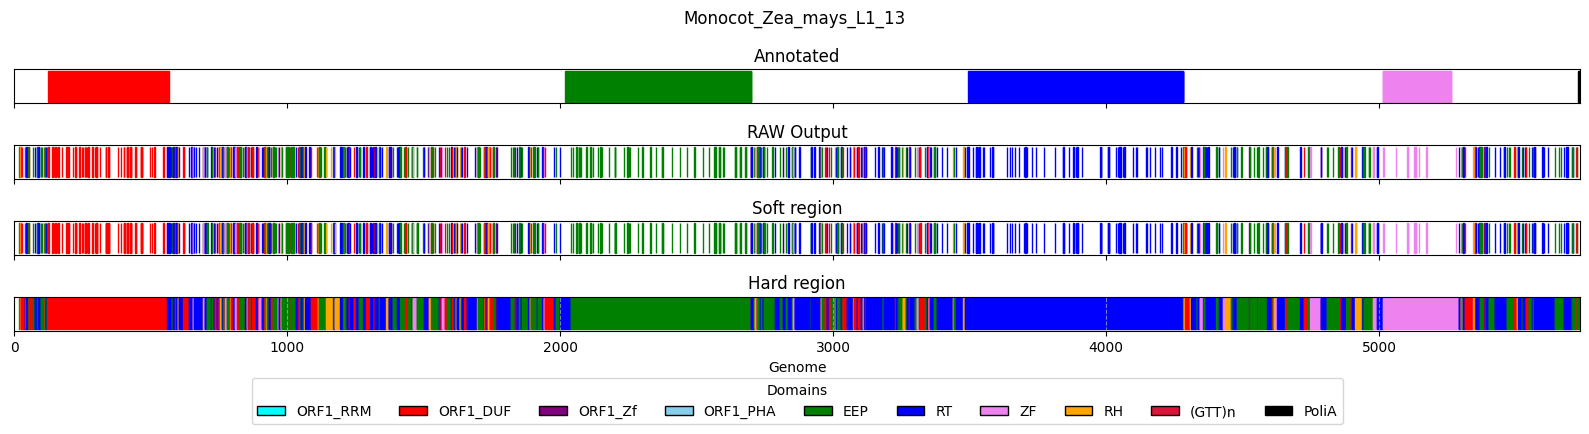

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_L1_13.png


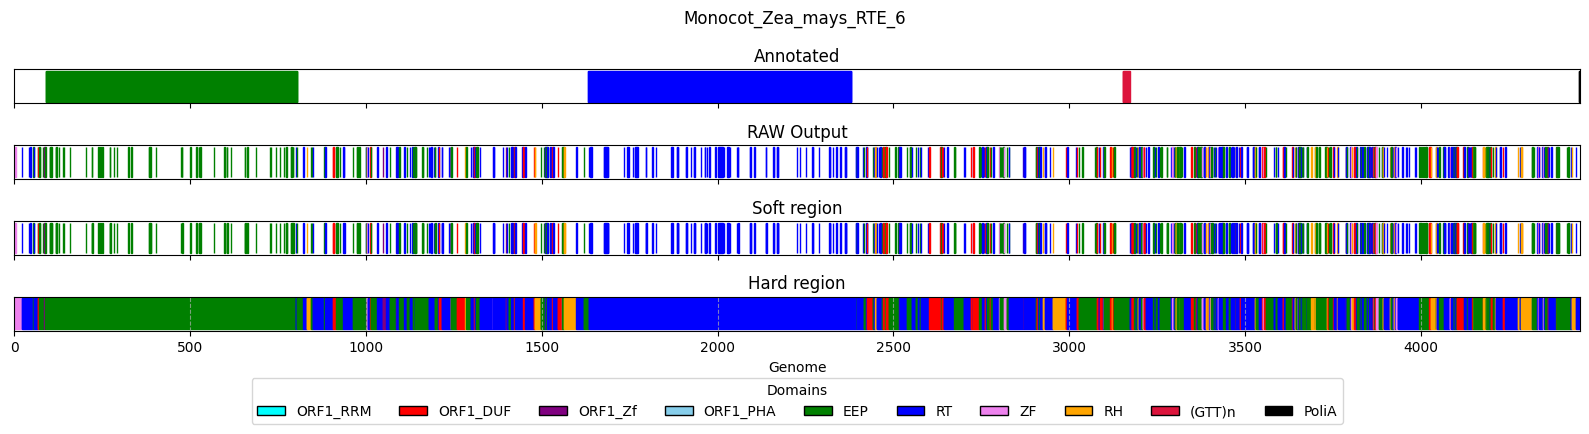

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_6.png


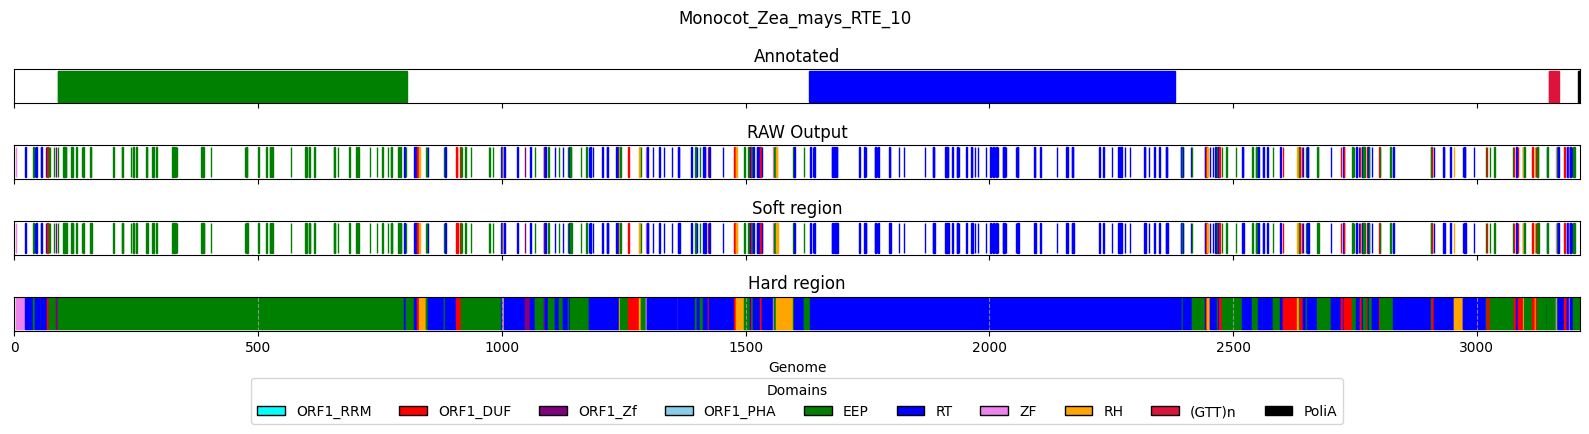

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_10.png


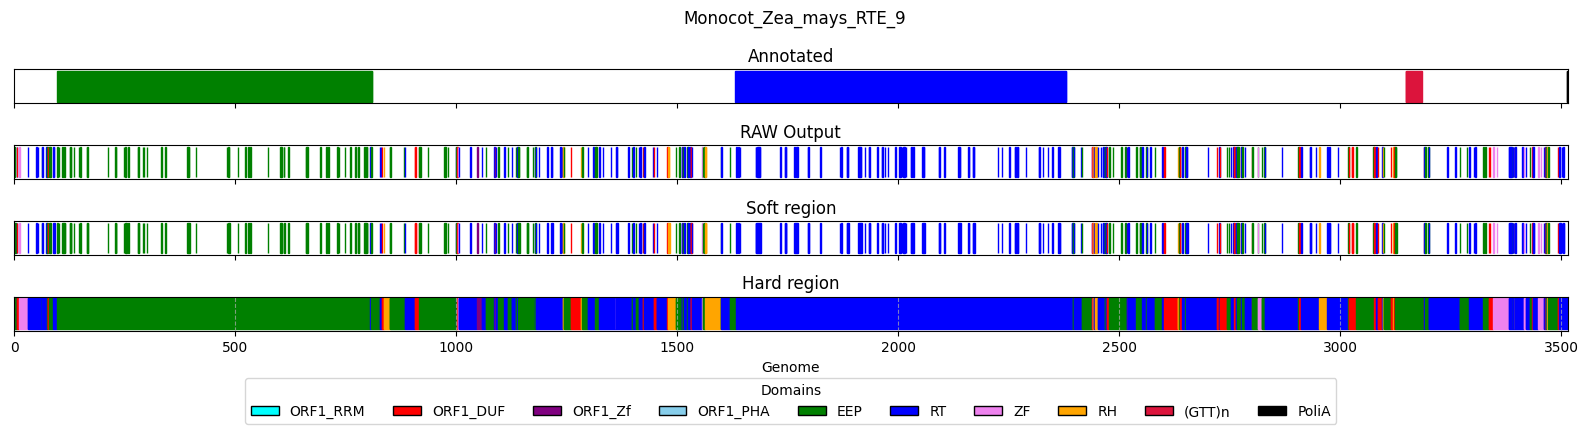

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_9.png


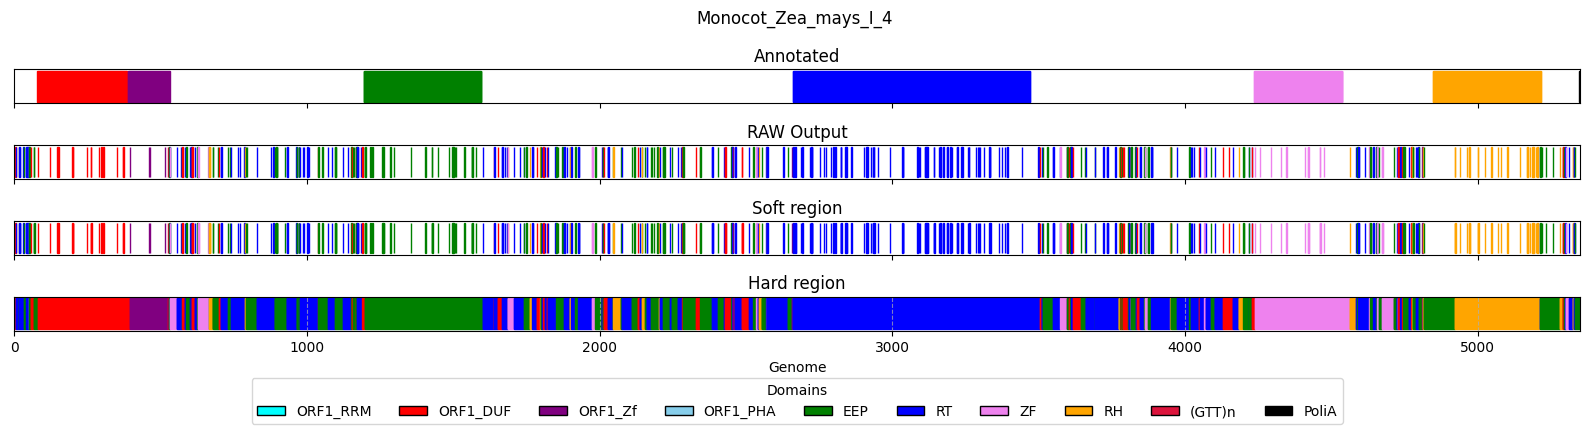

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_I_4.png


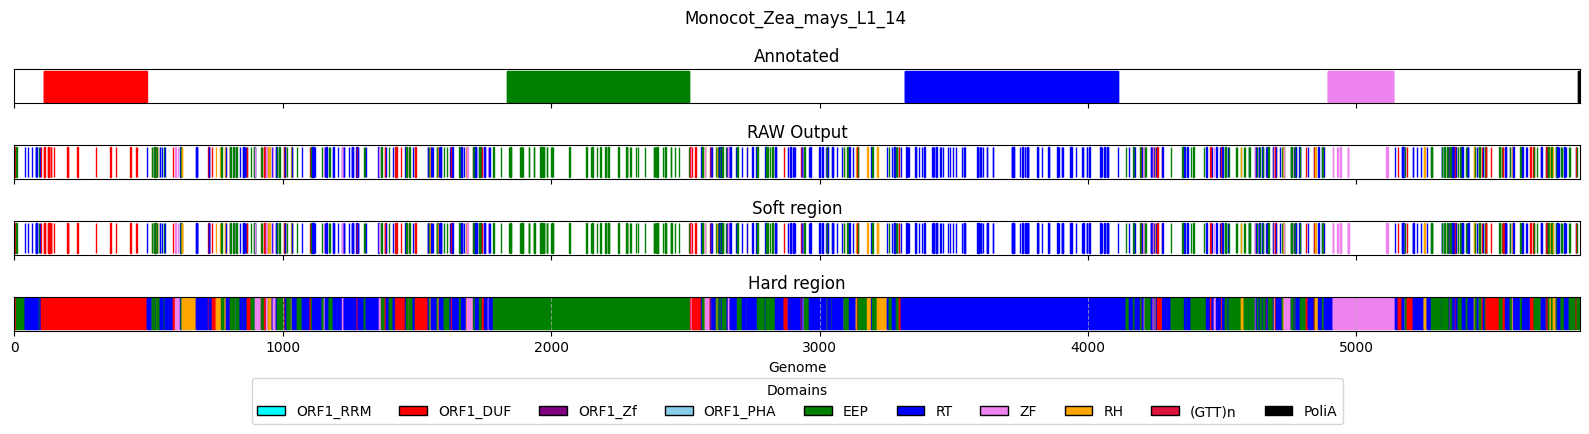

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_L1_14.png


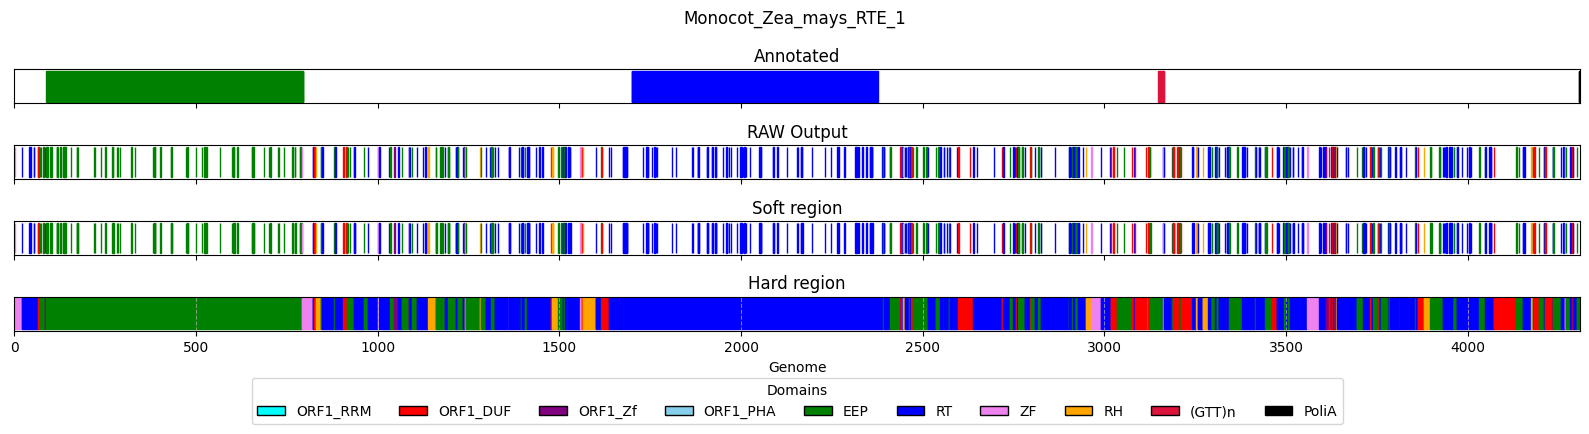

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_1.png


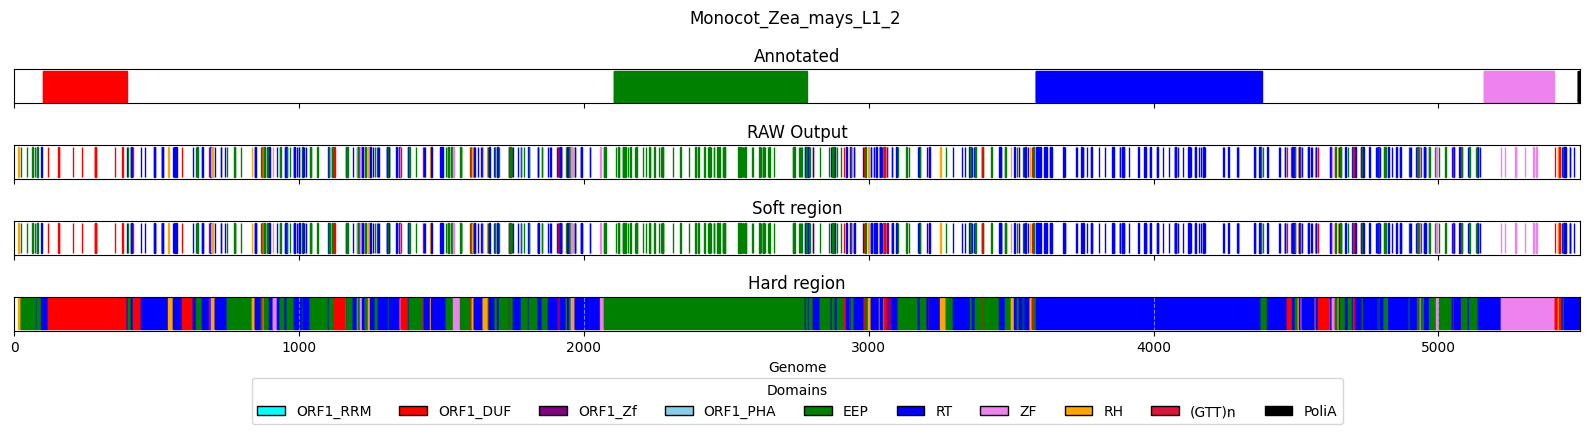

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_L1_2.png


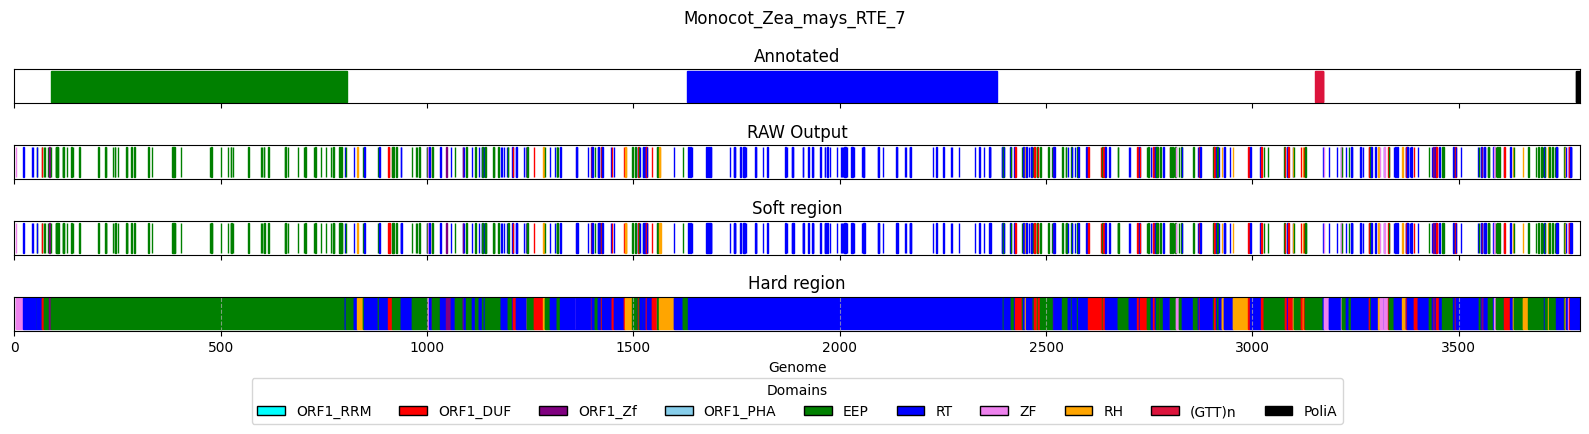

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_7.png


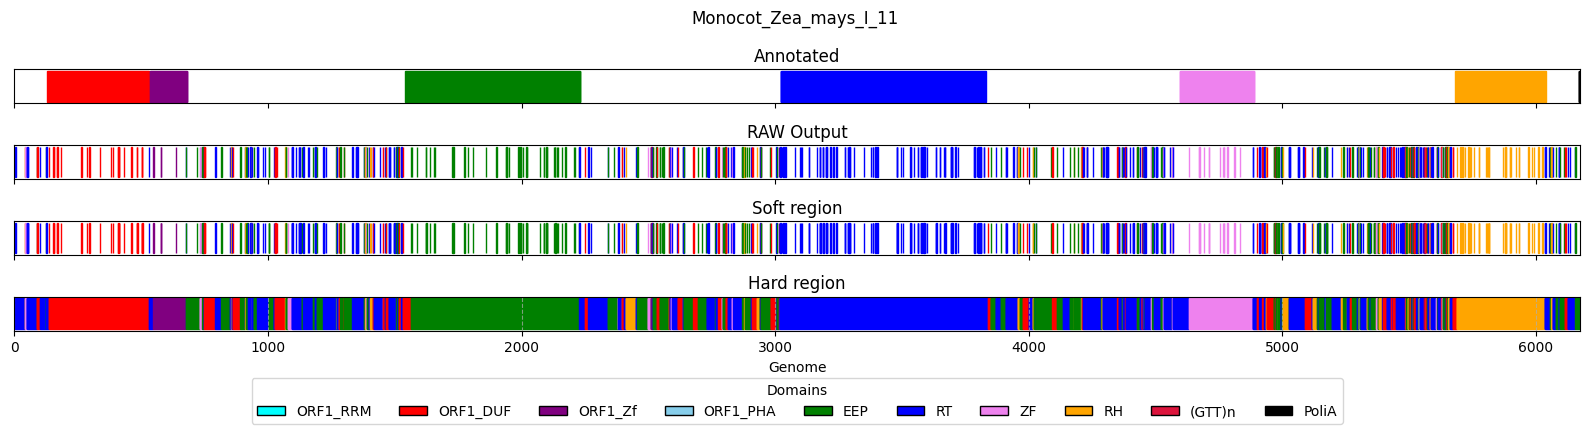

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_I_11.png


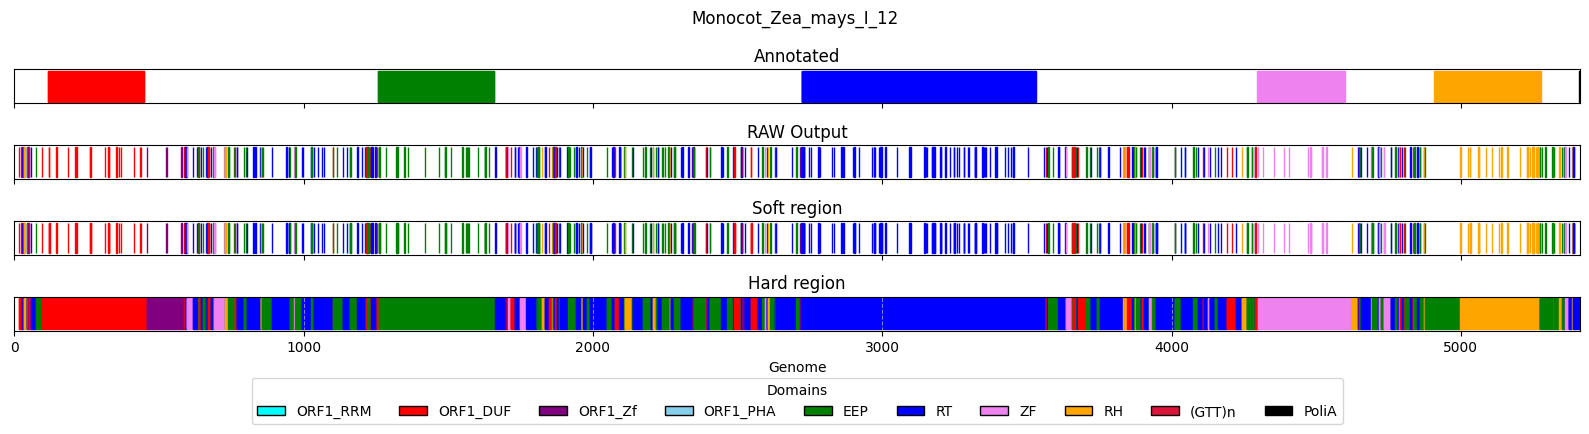

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_I_12.png


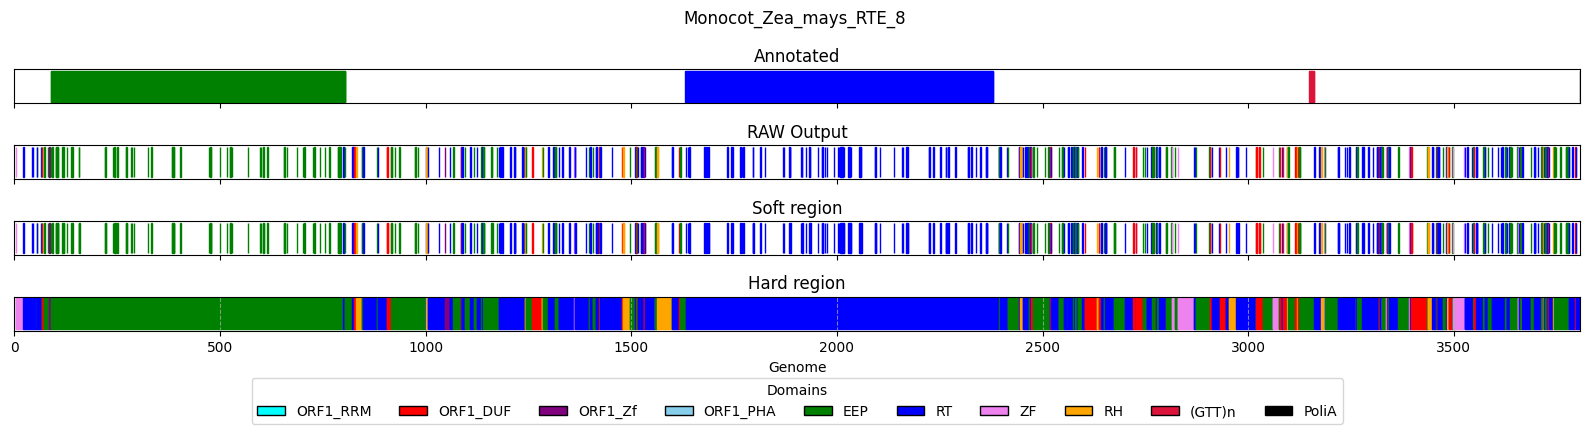

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_RTE_8.png


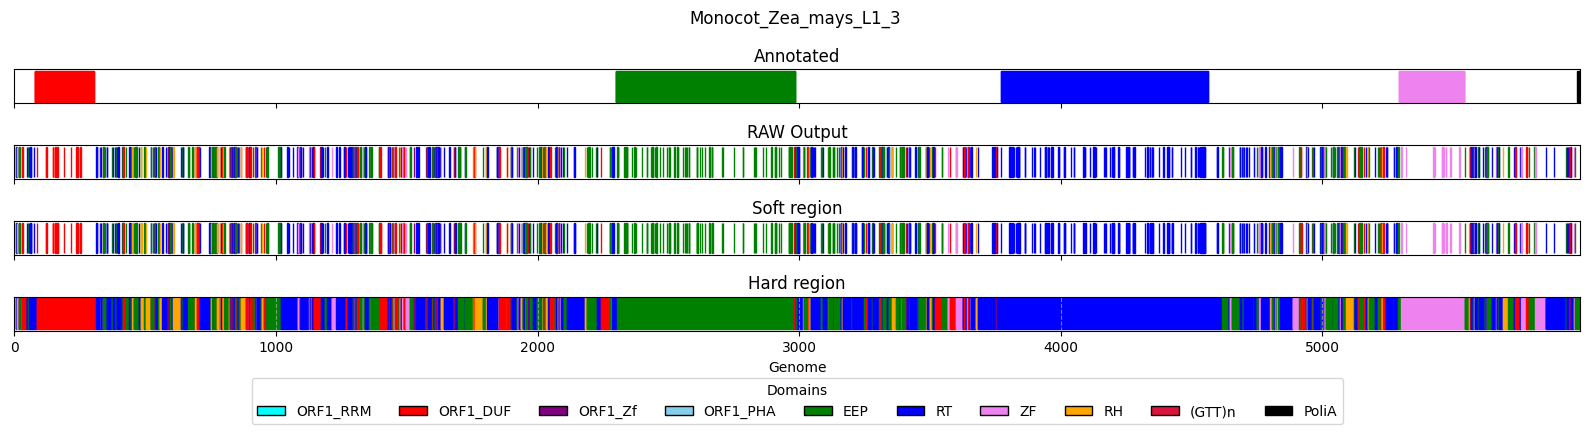

DONE FOR  ../data/Angiospermophyta/Monocots/Monocot_Zea_mays/LINESMonocot_Zea_mays_L1_3.png


In [12]:
# find regions in lines
# test folder (if exists)
# lines_folder = r'../data/domains/Monocot_Acorus_gramineus/LINES/teste/' # CHANGE FOR THE REAL PATH AND ORGANISM

file_list = [name for name in os.listdir(lines_folder) if fnmatch(name, "*.fasta")]
files = [lines_folder + "/" + file_name for file_name in file_list]

# Find annotations in lines metadata
for file_in in files:
    file_name = file_in.split('/')[-1].split('.fasta')[0]
    line_regions = []
    annot_regions = None
    with open(file_in, encoding="utf-8") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            seq = str(record.seq).upper()
            seq_name = str(record.id)
            seq_len = len(seq)
            i = 0
            while (i + word) < seq_len:
                line_regions.append(kmers_domains.get(seq[i : i + word]))
                i += step
            
            if seq_name in elements_files:
                temp_df = metadata[metadata['Name of elements'] == seq_name]
                seq_len_df = int(temp_df['Size (bp)'].iloc[0])
                if seq_len_df < seq_len:
                    seq_len_df = seq_len
                    
                regions = get_regions(temp_df)
                annot_regions = create_annot_regions(regions, seq_len_df)
                

    if annot_regions is not None:
        positions_annot = [i for i, value in enumerate(annot_regions) if value is not None]
        values_annot = [value for value in annot_regions if value is not None]


    # Soft regions
    line_regions_soft = fill_consecutive_nones(line_regions)
    positions_soft = [i for i, value in enumerate(line_regions_soft) if value is not None]
    values_soft = [value for value in line_regions_soft if value is not None]

    # Hard regions
    line_regions_hard = propagate_values(line_regions)
    positions_hard = [i for i, value in enumerate(line_regions_hard) if value is not None]
    values_hard = [value for value in line_regions_hard if value is not None]
    
    # Create Graphics for each file
    positions = [i for i, value in enumerate(line_regions) if value is not None]
    values = [value for value in line_regions if value is not None]

    # Define colors for each value
    color_map = {'ORF1_RRM': 'cyan',
              'ORF1_DUF': 'red',
              'ORF1_Zf': 'purple',
              'ORF1_PHA': 'skyblue',
              'EEP': 'green',
              'RT': 'blue',
              'ZF': 'violet',
              'RH': 'orange',
              '(GTT)n': 'crimson',
              'PoliA': 'black'}

    # Create a genome-style bar chart
    fig, axs = plt.subplots((4), figsize=(16, 5), sharex=True)
    
    # Loop through positions and values to create bars
    if annot_regions is not None:
        # Map values to colors
        colors_annot = [color_map[value] for value in values_annot]
        for pos, value, color in zip(positions_annot, values_annot, colors_annot):
            axs[0].barh(0, width=1, height=0.5, left=pos, color=color, edgecolor=color)
    
    # Loop through positions and values to create bars
    # Map values to colors
    colors = [color_map[value] for value in values]
    for pos, value, color in zip(positions, values, colors):
        axs[1].barh(0, width=1, height=0.5, left=pos, color=color, edgecolor=color)

    colors_soft = [color_map[value] for value in values_soft]
    for pos, value, color in zip(positions_soft, values_soft, colors_soft):
        axs[2].barh(0, width=1, height=0.5, left=pos, color=color, edgecolor=color)
        
    colors_hard = [color_map[value] for value in values_hard]
    for pos, value, color in zip(positions_hard, values_hard, colors_hard):
        axs[3].barh(0, width=1, height=0.5, left=pos, color=color, edgecolor=color)
        
    # Add labels and formatting
    
    plt.xlabel('Genome')
    fig.suptitle(file_name)
    plt.xlim(-0.5, len(line_regions) - 0.5)  # Add padding around the edges
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Create a legend
    axs[0].set_title("Annotated")
    axs[1].set_title("RAW Output")
    axs[2].set_title("Soft region")
    axs[3].set_title("Hard region")
    
    for ax in axs:
        ax.set_yticks([])
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for label, color in color_map.items()]
    plt.legend(handles=legend_elements,
               title="Domains", 
               loc='upper center', 
               bbox_to_anchor=(0.5, -1.2), 
               ncol=10)
    
    # Show the plot
    plt.tight_layout()
    file_name = file_name.replace('.', '_')
    fig_name = lines_folder + file_name + '.png'
    # If you want to save the figure, uncomment the following line
    # plt.savefig(fig_name, dpi=300)
    plt.show()
    print('DONE FOR ', fig_name)